不動産価格予測

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna japanize-matplotlib > /dev/null

In [ ]:
# ご自身のパスを設定
YOUR_PATH = "/content/drive/MyDrive/Colab Notebooks/nishika-mantion-summer"

In [ ]:
cd {YOUR_PATH}

/content/drive/MyDrive/Colab Notebooks/nishika-mantion-summer


In [ ]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from itertools import product
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OrdinalEncoder

## 実行環境の情報

dataディレクトリ配下に以下のようにデータを格納しているとする

├─ input<br>
│   ├─ data_explanation.xlsx<br>
│   ├─ sample_submission.csv<br>
│   ├─ test.csv<br>
│   └─ train<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 01.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 02.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 03.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ ...<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└─ 47.csv<br>
└─ output


メモリサイズ(GB)

In [ ]:
!cat /proc/meminfo | awk '($1=="MemTotal:") {print $2/1048576}'

12.6784


Pythonバージョン

In [ ]:
!python -V

Python 3.10.12


Pythonライブラリ情報

In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.8.5
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
alembic==1.12.0
altair==4.2.2
annotated-types==0.5.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.4.1
arviz==0.15.1
astropy==5.3.2
astunparse==1.6.3
async-timeout==4.0.3
attrs==23.1.0
audioread==3.0.0
autograd==1.6.2
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blinker==1.4
blis==0.7.10
blosc2==2.0.0
bokeh==3.2.2
branca==0.6.0
build==0.10.0
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.9
certifi==2023.7.22
cffi==1.15.1
chardet==5.2.0
charset-normalizer==3.2.0
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmaes==0.10.0
cmake==3.27.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlog==6.7.0
colorlover==0.3.0
community==1.0.0b1
confection==0.1.1
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.0
convertdate==2.4.0
cryptography==41.0.3
cufflinks==0.17.3
cvxopt==1.3.2
cvxpy==1.3.2
cycler==0.11.0
cymem==2.0.7

## 前処理

In [ ]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

In [ ]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [ ]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [ ]:
BASE_PATH = './data/'

In [ ]:
paths = glob(BASE_PATH + 'input/train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

<ipython-input-20-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
<ipython-input-20-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
<ipython-input-20-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
<ipython-input-20-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


In [ ]:
train_df.shape

(779404, 28)

In [ ]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              779404
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                672
最寄駅：名称            2796
最寄駅：距離（分）        23222
間取り              29150
面積（㎡）                0
土地の形状           779404
間口              779404
延床面積（㎡）         779404
建築年              22792
建物の構造            22320
用途               85676
今後の利用目的         368194
前面道路：方位         779404
前面道路：種類         779404
前面道路：幅員（ｍ）      779404
都市計画             20670
建ぺい率（％）          25309
容積率（％）           25309
取引時点                 0
改装               76361
取引の事情等          760032
取引価格（総額）_log         0
dtype: int64

In [ ]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [ ]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

In [ ]:
df = pd.concat([train_df, test_df])

rm_cols += ['市区町村コード']
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

<ipython-input-34-2a31c2b9037f>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,v in df.nunique().iteritems():


['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [ ]:
test_df[TARGET] = np.nan
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)
df = pd.concat([train_df, test_df])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(797798, 19)

In [ ]:
df['取引時点'].unique()

array(['2005年第3四半期', '2005年第4四半期', '2006年第1四半期', '2006年第2四半期',
       '2006年第3四半期', '2006年第4四半期', '2007年第1四半期', '2007年第2四半期',
       '2007年第3四半期', '2007年第4四半期', '2008年第1四半期', '2008年第2四半期',
       '2008年第3四半期', '2008年第4四半期', '2009年第1四半期', '2009年第2四半期',
       '2009年第3四半期', '2009年第4四半期', '2010年第1四半期', '2010年第2四半期',
       '2010年第3四半期', '2010年第4四半期', '2011年第1四半期', '2011年第2四半期',
       '2011年第3四半期', '2011年第4四半期', '2012年第1四半期', '2012年第2四半期',
       '2012年第3四半期', '2012年第4四半期', '2013年第1四半期', '2013年第2四半期',
       '2013年第3四半期', '2013年第4四半期', '2014年第1四半期', '2014年第2四半期',
       '2014年第3四半期', '2014年第4四半期', '2015年第1四半期', '2015年第2四半期',
       '2015年第3四半期', '2015年第4四半期', '2016年第1四半期', '2016年第2四半期',
       '2016年第3四半期', '2016年第4四半期', '2017年第1四半期', '2017年第2四半期',
       '2017年第3四半期', '2017年第4四半期', '2018年第1四半期', '2018年第2四半期',
       '2018年第3四半期', '2018年第4四半期', '2019年第1四半期', '2019年第2四半期',
       '2019年第3四半期', '2019年第4四半期', '2020年第1四半期', '2020年第2四半期',
       '2020年第3四半期', '2020年第4四半期', '2021年第1四半期', '2021年

In [ ]:
df[df['取引時点'].str.contains('202年第1四半期|2022年第2四半期')]

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
765716,13323516,東京都,葛飾区,白鳥,お花茶屋,9,３ＬＤＫ,70,令和3年,ＲＣ,住宅,住宅,工業地域,60.0,400.0,2022年第2四半期,未改装,NaN,7.716003
765717,13017325,東京都,新宿区,市谷田町,市ケ谷,8,３ＬＤＫ,70,平成12年,ＲＣ,住宅,住宅,第１種住居地域,60.0,300.0,2022年第2四半期,改装済,NaN,7.963788
765718,44005040,大分県,大分市,高城新町,高城,2,４ＬＤＫ,95,平成14年,ＳＲＣ,NaN,住宅,商業地域,80.0,400.0,2022年第2四半期,未改装,NaN,7.278754
765719,43002630,熊本県,熊本市中央区,新屋敷,新水前寺,18,３ＬＤＫ,70,平成16年,ＲＣ,住宅,住宅,近隣商業地域,80.0,300.0,2022年第2四半期,改装済,NaN,7.447158
765720,13074631,東京都,江東区,豊洲,豊洲,9,３ＬＤＫ,55,昭和55年,ＳＲＣ,住宅,住宅,準工業地域,60.0,300.0,2022年第2四半期,未改装,NaN,7.518514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779399,27004878,大阪府,大阪市西区,江之子島,阿波座,4,２ＬＤＫ,60,昭和57年,ＳＲＣ,住宅,住宅,商業地域,80.0,800.0,2022年第2四半期,未改装,NaN,7.278754
779400,26010558,京都府,京都市下京区,修徳学区,五条(京都市営),2,１Ｋ,20,昭和64年,鉄骨造,住宅,住宅,商業地域,80.0,700.0,2022年第2四半期,未改装,NaN,6.792392
779401,26026833,京都府,京都市西京区,桂稲荷山町,桂,10,３ＬＤＫ,65,昭和59年,ＲＣ,NaN,住宅,第２種住居地域,60.0,300.0,2022年第2四半期,NaN,NaN,7.255273
779402,26042848,京都府,城陽市,平川,久津川,2,２ＬＤＫ,70,平成7年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2022年第2四半期,改装済,NaN,7.380211


In [ ]:
val_min_idx = min(df[df['取引時点'].str.contains('2022年第1四半期|2022年第2四半期', regex=True)].index) # 該当の取引時点のindexを引っ張ってくる
test_min_idx = min(df[df['取引時点'].str.contains('2022年第3四半期|2022年第4四半期', regex=True)].index)
val_min_idx, test_min_idx

(751910, 779404)

In [ ]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2022年第1四半期', '2022年第2四半期'}

In [ ]:
# 2005年第3四半期 なら 0 , 2005年第4四半期 なら2 ・・・ と採番
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)



In [ ]:
tmp_df['取引時点'].unique()

array(['2005年第3四半期', '2005年第4四半期', '2006年第1四半期'], dtype=object)

In [ ]:
tmp = df[df[time_col] < 3]
tmp['取引時点'].unique()

array(['2005年第3四半期', '2005年第4四半期', '2006年第1四半期'], dtype=object)

In [ ]:
# 全期間での都道府県ごとの販売価格平均
df.groupby(by=group_col)[TARGET].mean()

都道府県名
三重県     7.112189
京都府     7.188175
佐賀県     7.042297
兵庫県     7.181087
北海道     7.004573
千葉県     7.172022
和歌山県    7.024580
埼玉県     7.189127
大分県     6.934705
大阪府     7.193511
奈良県     7.072308
宮城県     7.080598
宮崎県     6.996683
富山県     7.050774
山口県     7.050811
山形県     7.108513
山梨県     6.879155
岐阜県     7.096058
岡山県     7.079449
岩手県     6.940565
島根県     7.184293
広島県     7.132852
徳島県     6.966412
愛媛県     6.980456
愛知県     7.136562
新潟県     6.921512
東京都     7.410961
栃木県     6.951357
沖縄県     7.231170
滋賀県     7.193356
熊本県     7.010271
石川県     6.962238
神奈川県    7.277045
福井県     6.976325
福岡県     7.034649
福島県     7.000144
秋田県     6.955354
群馬県     6.936754
茨城県     7.086579
長崎県     7.177080
長野県     7.096715
青森県     6.960931
静岡県     7.033311
香川県     6.926725
高知県     7.003299
鳥取県     6.976729
鹿児島県    7.109666
Name: 取引価格（総額）_log, dtype: float64

In [ ]:
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

# 特定の期間以下の範囲で 各都道府県の販売価格の平均を取る(累計) ex ～20**年第◯四半期までの平均
for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()


In [ ]:
te_dic[50] # 50番目の取引時期"までの"都道府県ごとの販売価格平均

{'三重県': 7.099989772836439,
 '京都府': 7.155935848555253,
 '佐賀県': 7.009937258263509,
 '兵庫県': 7.157742870483196,
 '北海道': 6.965967793677859,
 '千葉県': 7.155825324964995,
 '和歌山県': 7.022690210815773,
 '埼玉県': 7.1697442713966355,
 '大分県': 6.911537826573079,
 '大阪府': 7.158352973821201,
 '奈良県': 7.056884610234688,
 '宮城県': 7.0395442538048805,
 '宮崎県': 6.958678653711235,
 '富山県': 7.0469200713870155,
 '山口県': 7.045342730349803,
 '山形県': 7.087990602814902,
 '山梨県': 6.848839888686708,
 '岐阜県': 7.078095913486453,
 '岡山県': 7.03809073492747,
 '岩手県': 6.925002679060599,
 '島根県': 7.165376214700312,
 '広島県': 7.093449021655064,
 '徳島県': 6.912051981629745,
 '愛媛県': 6.966433011596662,
 '愛知県': 7.107301969238601,
 '新潟県': 6.913835156235044,
 '東京都': 7.377929204641064,
 '栃木県': 6.950636958071011,
 '沖縄県': 7.160046604428336,
 '滋賀県': 7.16602695816839,
 '熊本県': 6.970182251843263,
 '石川県': 6.929363348877185,
 '神奈川県': 7.2581182672098175,
 '福井県': 6.979575815840195,
 '福岡県': 6.992264905042226,
 '福島県': 6.9743805791401785,
 '秋田県': 6.9413137471126

In [ ]:
# 先程作成した、te_dicを 各行に対して列追加していく
# 1行目であれば、東京都における、第1四半期より前までの全期間の平均を追加する。（取引時点_enc=0のときはデータがないので0になるけど。）

def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.head(2)

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,...,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
0,13381278,東京都,板橋区,蓮根,西台,2,２ＬＤＫ,60,平成17年,ＲＣ,...,NaN,商業地域,80.0,400.0,2005年第3四半期,未改装,NaN,7.544068,0,0.0
1,13070391,東京都,中央区,日本橋箱崎町,水天宮前,NaN,１Ｒ,20,平成17年,ＳＲＣ,...,NaN,商業地域,80.0,700.0,2005年第3四半期,未改装,NaN,7.361728,0,0.0


In [ ]:
# 例えば、 以下のように、 千葉、で 取引時点22年第4四半期 までの取引価格の平均は、7.172022..なので、それが入る
print(te_dic[69]['千葉県'])
df.tail()

7.1720221576584064


,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,...,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
797793,12165026,千葉県,四街道市,大日,四街道,25,３ＬＤＫ,60,平成7年,ＲＣ,...,住宅,第１種中高層住居専用地域,60.0,200.0,2022年第4四半期,未改装,調停・競売等,NaN,69,7.172022
797794,12165685,千葉県,四街道市,中央,四街道,8,３ＬＤＫ,75,平成21年,ＲＣ,...,住宅,第１種住居地域,60.0,200.0,2022年第4四半期,未改装,NaN,NaN,69,7.172022
797795,27032212,大阪府,大阪市住吉区,長居西,長居,9,２ＬＤＫ,65,平成3年,鉄骨造,...,住宅,第２種中高層住居専用地域,60.0,200.0,2022年第4四半期,未改装,NaN,NaN,69,7.193511
797796,27029577,大阪府,大阪市阿倍野区,阪南町,文の里,3,NaN,60,昭和59年,ＲＣ,...,住宅,第１種住居地域,80.0,300.0,2022年第4四半期,NaN,NaN,NaN,69,7.193511
797797,14009638,神奈川県,横浜市神奈川区,菅田町,片倉町,24,２ＬＤＫ,45,昭和46年,ＲＣ,...,住宅,第１種中高層住居専用地域,60.0,150.0,2022年第4四半期,改装済,NaN,NaN,69,7.277045


In [ ]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4])) # 2021からみて何年前に取引されたか? 2021になにかあった?
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [ ]:
df

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,...,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,13381278,東京都,板橋区,蓮根,西台,2.0,２ＬＤＫ,60,2005.0,ＲＣ,...,NaN,商業地域,80.0,400.0,未改装,NaN,7.544068,0,0.000000,16
1,13070391,東京都,中央区,日本橋箱崎町,水天宮前,NaN,１Ｒ,20,2005.0,ＳＲＣ,...,NaN,商業地域,80.0,700.0,未改装,NaN,7.361728,0,0.000000,16
2,13149676,東京都,江東区,永代,門前仲町,NaN,１Ｋ,25,2005.0,ＳＲＣ,...,NaN,商業地域,80.0,600.0,未改装,NaN,7.322219,0,0.000000,16
3,14138384,神奈川県,横浜市鶴見区,東寺尾,生麦,NaN,３ＬＤＫ,50,1989.0,ＲＣ,...,NaN,第２種中高層住居専用地域,60.0,150.0,未改装,NaN,6.875061,0,0.000000,16
4,14192676,神奈川県,横浜市保土ケ谷区,保土ケ谷町,保土ケ谷,9.0,１Ｋ,15,1991.0,ＳＲＣ,...,NaN,NaN,NaN,NaN,未改装,NaN,6.755875,0,0.000000,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797793,12165026,千葉県,四街道市,大日,四街道,25.0,３ＬＤＫ,60,1995.0,ＲＣ,...,住宅,第１種中高層住居専用地域,60.0,200.0,未改装,調停・競売等,NaN,69,7.172022,-1
797794,12165685,千葉県,四街道市,中央,四街道,8.0,３ＬＤＫ,75,2009.0,ＲＣ,...,住宅,第１種住居地域,60.0,200.0,未改装,NaN,NaN,69,7.172022,-1
797795,27032212,大阪府,大阪市住吉区,長居西,長居,9.0,２ＬＤＫ,65,1991.0,鉄骨造,...,住宅,第２種中高層住居専用地域,60.0,200.0,未改装,NaN,NaN,69,7.193511,-1
797796,27029577,大阪府,大阪市阿倍野区,阪南町,文の里,3.0,NaN,60,1984.0,ＲＣ,...,住宅,第１種住居地域,80.0,300.0,NaN,NaN,NaN,69,7.193511,-1


In [ ]:
def select_categorical(df: pd.DataFrame):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    return df[categorical_columns].copy()

def select_numerical(df: pd.DataFrame):
    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    return df[numerical_columns].copy()

def encode_labels(df: pd.DataFrame):
    df.fillna("Missing", inplace = True)
    for col in df.columns:
        encoded = LabelEncoder().fit_transform(df[col].copy())
        df[col] = encoded
    return df

# 容積率 = 延べ床面積 / 敷地面積 実質、延べ床面積を算出してる
def combinate_yoseki(df: pd.DataFrame):
    df["面積（㎡）容積率（％）_combi"] = df["面積（㎡）"] * df["容積率（％）"]
    return df[["面積（㎡）容積率（％）_combi"]].copy()


In [ ]:
num_df = FunctionTransformer(select_numerical).fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,13058014,1.0,20,2005.0,80.0,600.0,7.361728,0,0.0,16
1,27275255,NaN,65,1975.0,80.0,300.0,6.892095,0,0.0,16


In [ ]:
encoder = make_pipeline(
    FunctionTransformer(select_categorical),
    FunctionTransformer(encode_labels),
)

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,26,117,9172,1567,7,5,7,0,1,2,0
1,9,201,6017,535,28,5,7,0,6,2,0


In [ ]:
encoder = make_pipeline(
    FunctionTransformer(select_numerical),
    FunctionTransformer(combinate_yoseki),
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,120.0
1,195.0


In [ ]:
agg_df = df.groupby(group_col).agg({
    "最寄駅：距離（分）": ["count", "mean", "min", "max"],
    "面積（㎡）": ["count", "mean", "min", "max"],
    "建ぺい率（％）": ["count", "mean", "min", "max"],
    "容積率（％）": ["count", "mean", "min", "max"]
}).reset_index()

In [ ]:
agg_df

市区町村名 最寄駅：距離（分）                         面積（㎡）                      \
                  count       mean   min    max count       mean min  max   
0       あきる野市        27   9.851852   2.0   18.0    27  64.629630  55   80   
1         あま市       237  17.552743   3.0   45.0   238  74.117647  50  110   
2        いわき市       255  18.466667   3.0  120.0   255  62.039216  20   95   
3        うるま市         0        NaN   NaN    NaN    25  72.600000  40  145   
4    さいたま市中央区      1195  10.745607   1.0  120.0  1203  65.394846  15  160   
..        ...       ...        ...   ...    ...   ...        ...  ..  ...   
614       鶴岡市        34  16.176471   2.0   45.0    34  67.205882  25  135   
615      鹿児島市      2016  18.456349   0.0  120.0  2122  64.250707  15  520   
616       鹿屋市         0        NaN   NaN    NaN     8  78.125000  65  100   
617       鹿沼市        17  14.882353  11.0   19.0    17  75.294118  60   85   
618      龍ケ崎市       254  25.925197   3.0  105.0   254  66.850394  45  100   

    建ぺい率（％）                        容積率（％）                            
      count       mean   min   max  count        mean    min    max  
0        27  60.740741  60.0  80.0     27  240.740741  200.0  300.0  
1       233  60.000000  60.0  60.0    233  200.000000  200.0  200.0  
2       255  74.039216  60.0  80.0    255  362.352941  200.0  600.0  
3        24  62.083333  60.0  80.0     24  187.500000  100.0  400.0  
4      1170  63.059829  60.0  80.0   1170  226.538462  100.0  600.0  
..      ...        ...   ...   ...    ...         ...    ...    ...  
614      34  70.882353  60.0  80.0     34  305.882353  200.0  400.0  
615    1643  69.598296  50.0  80.0   1643  300.468655   80.0  800.0  
616       2  60.000000  60.0  60.0      2  200.000000  200.0  200.0  
617      17  70.588235  60.0  80.0     17  305.882353  200.0  400.0  
618     243  58.106996  50.0  80.0    243  179.835391  100.0  400.0  

[619 rows x 17 columns]

In [ ]:
group_col = '市区町村名'
agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
cols = [group_col] + agg_cols # リスト結合 ['市区町村名', '最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）']
agg_df = df[cols].copy()
functions = ["count", "mean", "min", "max"]

for col, function in product(agg_cols, functions): # productを使うと 2つの引数のすべての組み合わせを返す ex 最寄駅：距離（分） count ,  最寄駅：距離（分） mean 最寄駅：距離（分） min
    print(f'{col} : {function}')
    col_name = f"{col}_{function}"
    agg_df[col_name] = agg_df.groupby(group_col)[col].transform(function)
    break
agg_df

最寄駅：距離（分） : count


,市区町村名,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,最寄駅：距離（分）_count
0,板橋区,2.0,60,80.0,400.0,10700
1,中央区,NaN,20,80.0,700.0,10176
2,江東区,NaN,25,80.0,600.0,14339
3,横浜市鶴見区,NaN,50,60.0,150.0,4573
4,横浜市保土ケ谷区,9.0,15,NaN,NaN,2736
...,...,...,...,...,...,...
797793,四街道市,25.0,60,60.0,200.0,183
797794,四街道市,8.0,75,60.0,200.0,183
797795,大阪市住吉区,9.0,65,60.0,200.0,996
797796,大阪市阿倍野区,3.0,60,80.0,300.0,1688


In [ ]:
group_col = '市区町村名'
agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
cols = [group_col] + agg_cols # リスト結合 ['市区町村名', '最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）']
agg_df = df[cols].copy()
functions = ["count", "mean", "min", "max"]

agg_df.groupby(group_col)["最寄駅：距離（分）"].agg('count')

市区町村名
あきる野市         27
あま市          237
いわき市         255
うるま市           0
さいたま市中央区    1195
            ... 
鶴岡市           34
鹿児島市        2016
鹿屋市            0
鹿沼市           17
龍ケ崎市         254
Name: 最寄駅：距離（分）, Length: 619, dtype: int64

In [ ]:
agg_dfs = []

# group_col（ここでは市区町村名）でgroupbyして agg_colsで指定したデータを count/mean/min/max集計する。
def get_agg_df(df, group_col):
    # 以下は市区町村ごと かつ 各特徴量ごとに 集計 市区町村数は619なので、 以下のagg_dfも619行
    # agg_df = df.groupby(group_col).agg({
    #     "最寄駅：距離（分）": ["count", "mean", "min", "max"],
    #     "面積（㎡）": ["count", "mean", "min", "max"],
    #     "建ぺい率（％）": ["count", "mean", "min", "max"],
    #     "容積率（％）": ["count", "mean", "min", "max"]
    # }).reset_index()
    agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
    cols = [group_col] + agg_cols # リスト結合 ['市区町村名', '最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）']
    agg_df = df[cols].copy()
    functions = ["count", "mean", "min", "max"]
    for col, function in product(agg_cols, functions): # productを使うと 2つの引数のすべての組み合わせを返す ex 最寄駅：距離（分） count ,  最寄駅：距離（分） mean 最寄駅：距離（分） min
        col_name = f"{col}_{function}"
        agg_df[col_name] = agg_df.groupby(group_col)[col].transform(function) # transform()を使うと、groupbyで集計したデータを元データに結合できる
    return agg_df.drop(cols, axis = 1)

# 市区町村ごとに、agg_colsの count/mean/min/maxを作る
group_col = '市区町村名'
agg_df = get_agg_df(df, group_col)
agg_df.head(2)

,最寄駅：距離（分）_count,最寄駅：距離（分）_mean,最寄駅：距離（分）_min,最寄駅：距離（分）_max,面積（㎡）_count,面積（㎡）_mean,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,10700,7.388131,0.0,120.0,11208,45.376963,10,260,11060,67.460217,40.0,80.0,11060,302.468354,80.0,800.0
1,10176,4.304147,0.0,45.0,10571,43.881374,10,2000,10416,76.722350,60.0,80.0,10416,539.199309,100.0,900.0


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['最寄駅：距離（分）_count'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['最寄駅：距離（分）_mean'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['最寄駅：距離（分）_max'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['最寄駅：距離（分）_count'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['最寄駅：距離（分）_mean'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['最寄駅：距離（分）_max'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_8, *[[['index', '最寄駅：距離（分）_count'], ['最寄駅：距離（分）_count', '最寄駅：距離（分）_mean'], ['最寄駅：距離（分）_mean', '最寄駅：距離（分）_max'], ['最寄駅：距離（分）_max', '面積（㎡）_count']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_9, *['index', '最寄駅：距離（分）_count', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_10, *['index', '最寄駅：距離（分）_mean', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_11, *['index', '最寄駅：距離（分）_max', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_12, *['index', '面積（㎡）_count', None], **{})
chart

In [ ]:
agg_df.shape

(797798, 16)

In [ ]:
feat_df = pd.concat([num_df,le_df,num_comb_df, agg_df], axis=1)
print(feat_df.shape)

(797798, 38)


In [ ]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前,...,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,13058014,1.0,20,2005.0,80.0,600.0,7.361728,0,0.0,16,...,10,1500,3793,77.769576,60.0,80.0,3793,572.001055,300.0,900.0
1,27275255,NaN,65,1975.0,80.0,300.0,6.892095,0,0.0,16,...,35,1100,1504,68.590426,50.0,80.0,1504,232.081117,150.0,400.0
2,13450951,21.0,80,1992.0,60.0,200.0,7.397940,0,0.0,16,...,10,440,8354,65.497965,50.0,80.0,8354,301.909265,100.0,600.0
3,14319499,NaN,50,1974.0,60.0,200.0,7.204120,0,0.0,16,...,10,270,2278,67.251975,60.0,80.0,2278,276.799824,150.0,600.0
4,13109559,NaN,20,2005.0,80.0,600.0,7.380211,0,0.0,16,...,10,1000,12492,72.295869,50.0,80.0,12492,445.072847,100.0,900.0


In [ ]:
feat_df.isnull().sum()

ID                       0
最寄駅：距離（分）            23227
面積（㎡）                    0
建築年                  23275
建ぺい率（％）              25626
容積率（％）               25626
取引価格（総額）_log         18394
取引時点_enc                 0
都道府県名_te                 0
取引時点_何年前                 0
都道府県名                    0
市区町村名                    0
地区名                      0
最寄駅：名称                   0
間取り                      0
建物の構造                    0
用途                       0
今後の利用目的                  0
都市計画                     0
改装                       0
取引の事情等                   0
面積（㎡）容積率（％）_combi    25626
最寄駅：距離（分）_count          0
最寄駅：距離（分）_mean         256
最寄駅：距離（分）_min          256
最寄駅：距離（分）_max          256
面積（㎡）_count              0
面積（㎡）_mean               0
面積（㎡）_min                0
面積（㎡）_max                0
建ぺい率（％）_count            0
建ぺい率（％）_mean             8
建ぺい率（％）_min              8
建ぺい率（％）_max              8
容積率（％）_count             0
容積率（％）_mean              8
容積率（％）_min               8
容

モデル構築

In [ ]:
feat_df.columns

Index(['ID', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引価格（総額）_log',
       '取引時点_enc', '都道府県名_te', '取引時点_何年前', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '改装', '取引の事情等',
       '面積（㎡）容積率（％）_combi', '最寄駅：距離（分）_count', '最寄駅：距離（分）_mean',
       '最寄駅：距離（分）_min', '最寄駅：距離（分）_max', '面積（㎡）_count', '面積（㎡）_mean',
       '面積（㎡）_min', '面積（㎡）_max', '建ぺい率（％）_count', '建ぺい率（％）_mean',
       '建ぺい率（％）_min', '建ぺい率（％）_max', '容積率（％）_count', '容積率（％）_mean',
       '容積率（％）_min', '容積率（％）_max'],
      dtype='object')

In [ ]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(751910, 38) (27494, 38) (18394, 38)


In [ ]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [ ]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [ ]:
train_df.columns

Index(['ID', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引価格（総額）_log',
       '取引時点_enc', '都道府県名_te', '取引時点_何年前', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '改装', '取引の事情等',
       '面積（㎡）容積率（％）_combi', '最寄駅：距離（分）_count', '最寄駅：距離（分）_mean',
       '最寄駅：距離（分）_min', '最寄駅：距離（分）_max', '面積（㎡）_count', '面積（㎡）_mean',
       '面積（㎡）_min', '面積（㎡）_max', '建ぺい率（％）_count', '建ぺい率（％）_mean',
       '建ぺい率（％）_min', '建ぺい率（％）_max', '容積率（％）_count', '容積率（％）_mean',
       '容積率（％）_min', '容積率（％）_max'],
      dtype='object')

In [ ]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [ ]:
train_x.isnull().sum()

最寄駅：距離（分）            23202
面積（㎡）                    0
建築年                  21937
建ぺい率（％）              24757
容積率（％）               24757
取引時点_enc                 0
都道府県名_te                 0
取引時点_何年前                 0
都道府県名                    0
市区町村名                    0
地区名                      0
最寄駅：名称                   0
間取り                      0
建物の構造                    0
用途                       0
今後の利用目的                  0
都市計画                     0
改装                       0
取引の事情等                   0
面積（㎡）容積率（％）_combi    24757
最寄駅：距離（分）_count          0
最寄駅：距離（分）_mean         250
最寄駅：距離（分）_min          250
最寄駅：距離（分）_max          250
面積（㎡）_count              0
面積（㎡）_mean               0
面積（㎡）_min                0
面積（㎡）_max                0
建ぺい率（％）_count            0
建ぺい率（％）_mean             8
建ぺい率（％）_min              8
建ぺい率（％）_max              8
容積率（％）_count             0
容積率（％）_mean              8
容積率（％）_min               8
容積率（％）_max               8
dtype: int64

In [ ]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(val_x, label=val_y)

model = lgb.train(
    params,
    train_data,
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data],
    verbose_eval = 100,
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['今後の利用目的', '取引の事情等', '取引時点_enc', '地区名', '市区町村名', '建物の構造', '改装', '最寄駅：名称', '用途', '都市計画', '都道府県名', '間取り']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Refere

Training until validation scores don't improve for 100 rounds
[100]	train's l1: 0.0810878	valid's l1: 0.107107
[200]	train's l1: 0.0765754	valid's l1: 0.10349
[300]	train's l1: 0.0743205	valid's l1: 0.102168
[400]	train's l1: 0.0731074	valid's l1: 0.101531
[500]	train's l1: 0.0719508	valid's l1: 0.101004
[600]	train's l1: 0.0712343	valid's l1: 0.100649
[700]	train's l1: 0.0705341	valid's l1: 0.100134
[800]	train's l1: 0.0699813	valid's l1: 0.0999355
[900]	train's l1: 0.0694217	valid's l1: 0.0997906
Early stopping, best iteration is:
[899]	train's l1: 0.069426	valid's l1: 0.0997846
score: 0.0998


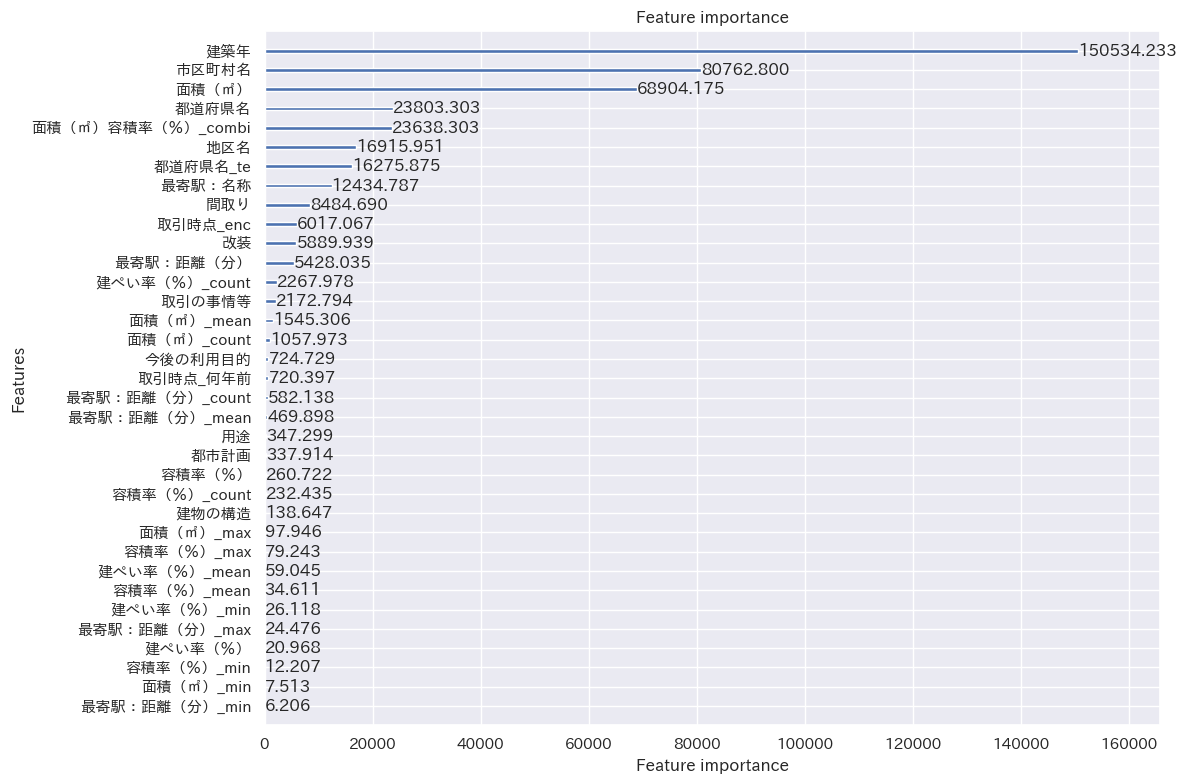

In [ ]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

## 推論

In [ ]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

In [ ]:
test_df[TARGET] = test_pred

<ipython-input-45-c7d24f824a6c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET] = test_pred


In [ ]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)